In [83]:
import sys
import pybullet as p
import pybullet_data
import time
import random
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import torch 
import torch.nn as nn
import torch.optim as optim

path="/its/home/drs25/Documents/GitHub/Sim-Biped-Walker/URDF_files/walker_assembly/"
if sys.platform.startswith('win'):
    path="C:/Users/dexte/Documents/GitHub/Sim-Biped-Walker/URDF_files/walker_assembly/"
robot_urdf_path = "urdf/walker_assembly.urdf"  # Replace with the actual path to your URDF file

sys.path.append("/its/home/drs25/Documents/GitHub/Sim-Biped-Walker/Code/")
import Biped_controller as bp

## Physics and robot creation

In [16]:
def createEngine():
    # Initialize PyBullet
    physicsClient = p.connect(p.GUI)  # or p.DIRECT for non-graphical version
    # Remove all objects
    num_objects = p.getNumBodies()
    for i in range(num_objects):
        p.removeBody(p.getBodyUniqueId(i))

    # Reset the environment
    p.resetSimulation()
    p.setAdditionalSearchPath(path)  # Set the path for urdf files
    p.setAdditionalSearchPath(pybullet_data.getDataPath())  # Set the path for urdf files
    # Load ground plane
    p.loadURDF("plane.urdf",[0, 0, 0])  # Assuming there's a plane.urdf file in the pybullet data path
    # Load URDF file
    gravity = [0, 0, -9.8]
    p.setGravity(gravity[0], gravity[1], gravity[2])

def reset():
    num_objects = p.getNumBodies()
    for i in range(num_objects):
        p.removeBody(p.getBodyUniqueId(i))
    # Reset the environment
    p.resetSimulation()
    p.loadURDF("plane.urdf",[0, 0, 0])  # Assuming there's a plane.urdf file in the pybullet data path
    # Load URDF file
    gravity = [0, 0, -9.8]
    p.setGravity(gravity[0], gravity[1], gravity[2])

createEngine()
robot=bp.Biped(p,path+robot_urdf_path)

error: Only one local in-process GUI/GUI_SERVER connection allowed. Use DIRECT connection mode or start a separate GUI physics server (ExampleBrowser, App_SharedMemoryPhysics_GUI, App_SharedMemoryPhysics_VR) and connect over SHARED_MEMORY, UDP or TCP instead.

In [ ]:
print(robot.get_orientation())
start_pos=robot.get_position()
robot.set_positions([0.1,0.5,0.5,0.8])
for _ in range(100):  # Run the simulation for 1000 steps (adjust as needed)
    p.stepSimulation()
    time.sleep(1./240.)
print(robot.orientation)

(-7.403932178333501e-18, -7.822274398480377e-17, 2.2034421452109355e-18)
[-7.403932178333501e-18, -7.822274398480377e-17, 2.2034421452109355e-18]


## Evolution functions

In [235]:
def fitness_func(robot,startpos,endpos):
    fitness=0
    #distances=np.linalg.norm(np.array(startpos) - np.array(endpos))
    orientation=robot.get_orientation()
    dist=np.linalg.norm(np.array(robot.orientation) - np.array(orientation))
    if dist>2:
        #fallen over robot
        return fitness
    x_dist=startpos[1]-endpos[1]
    other=np.abs(np.array(startpos)-np.array(endpos))
    other=other[0]+other[2]
    return x_dist-other

import numpy as np

class NeuralNetwork:
    def __init__(self, input_size, hidden_layers, output_size):
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.output_size = output_size
        
        # Initialize weights and biases
        self.weights = []
        self.biases = []
        
        # Initialize weights and biases for hidden layers
        for i, layer_size in enumerate(hidden_layers):
            if i == 0:
                input_layer_size = input_size
            else:
                input_layer_size = hidden_layers[i-1]
            self.weights.append(np.random.randn(input_layer_size,layer_size))
            self.biases.append(np.random.randn(1,layer_size))
        
        # Initialize weights and biases for output layer
        self.weights.append(np.random.randn(hidden_layers[-1],output_size))
        self.biases.append(np.random.randn(1,output_size))
        
    def forward(self, x):
        # Forward pass through the network
        for i in range(len(self.weights)-1):
            z = np.dot(x,self.weights[i]) + self.biases[i]
            x = self.sigmoid(z) if i < len(self.weights) - 1 else self.softmax(z)
        x = np.dot(x,self.weights[-1]) + self.biases[-1]
        return self.tanh_activation(x)/10
    def count_parameters(self):
        # Count total number of values in weights and biases
        total_parameters = sum(np.size(w) for w in self.weights) + sum(np.size(b) for b in self.biases)
        return total_parameters
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    def tanh_activation(self,x):
        return np.tanh(x)
    def softmax(self, z):
        exp_z = np.exp(z)
        return exp_z / np.sum(exp_z, axis=0)
    
    def mutate(self, mutation_array):
        # Mutate weights and biases using Gaussian noise
        index = 0
        for i in range(len(self.weights)):
            self.weights[i] += mutation_array[index: index + self.weights[i].size].reshape(self.weights[i].shape)
            index += self.weights[i].size
        for i in range(len(self.biases)):
            self.biases[i] += mutation_array[index: index + self.biases[i].size].reshape(self.biases[i].shape)
            index += self.biases[i].size
    def set_genes(self, genes):
        # Assign weights and biases using the provided array
        index = 0
        for i in range(len(self.weights)):
            self.weights[i] = genes[index: index + self.weights[i].size].reshape(self.weights[i].shape)
            index += self.weights[i].size
        for i in range(len(self.biases)):
            self.biases[i] = genes[index: index + self.biases[i].size].reshape(self.biases[i].shape)
            index += self.biases[i].size

class RNN:
    def __init__(self,num,hidden): #initialize parameters
        self.weights1=nn.Linear(num,hidden)
        self.weights2=nn.Linear(hidden,num)
        self.gene_num=num*hidden + hidden*num + hidden + num
        self.parameters=[]
        for param in self.weights1.parameters():
            self.parameters.append(param)
        for param in self.weights2.parameters():
            self.parameters.append(param)  
    def forward(self,x): #forward pass
        h=torch.tanh(self.weights1(x))
        o=(self.weights2(h))
        return o
    def set_genes(self,genes): # set genes over current weights and biases
        idx=0
        idxe=0
        for param in self.weights1.parameters():
            idxe=len(param.data.flatten())
            shape=param.data.shape
            param.data=genes[idx:idx+idxe].reshape(shape)
            idx+=idxe
        for param in self.weights2.parameters():
            idxe=len(param.data.flatten())
            shape=param.data.shape
            param.data=genes[idx:idx+idxe].reshape(shape)
            idx+=idxe
    def mutate(self,genes): #mutate neural network
        idx=0
        idxe=0
        for param in self.weights1.parameters():
            idxe=len(param.data.flatten())
            shape=param.data.shape
            param.data+=genes[idx:idx+idxe].reshape(shape)
            idx+=idxe
        for param in self.weights2.parameters():
            idxe=len(param.data.flatten())
            shape=param.data.shape
            param.data+=genes[idx:idx+idxe].reshape(shape)
            idx+=idxe
    def get_genes(self):
        data=torch.tensor([])
        for param in self.weights1.parameters():
            data=torch.concatenate([data,param.data.flatten()])
        for param in self.weights2.parameters():
            data=torch.concatenate([data,param.data.flatten()])
        return data
    
m=RNN(5,4)
print(m.gene_num)
genes=m.get_genes()
print(len(genes))
m.set_genes(genes)

49
49


In [ ]:
nn=NeuralNetwork(5,[10],2)
nn.forward(np.random.normal(0,1,(4,5)))
noise=np.random.normal(0,5,(nn.count_parameters(),))
nn.mutate(noise)
reset()
robot=bp.Biped(p,path+robot_urdf_path,position=[0, 0, .15])
for _ in range(50):  # Run the simulation for 1000 steps (adjust as needed)
    p.stepSimulation()
    time.sleep(1./240.)

## GA

In [249]:
def runTrial(agent,time_max,co=0,show=False):
    dt=0.01
    timer=0
    reset()
    robot=bp.Biped(p,path+robot_urdf_path,position=[0, 0, .15])
    start_pos=robot.get_position()
    while timer<time_max:
        friction=torch.tensor([co])
        positions=torch.tensor(robot.positions())
        out=agent.forward(positions)#np.concatenate([positions,friction],axis=0))
        outputs=out.flatten()
        outputs[outputs>.5]=.5
        outputs[outputs<-.5]=-.5
        robot.set_positions(outputs)
        p.stepSimulation()
        if show: time.sleep(1./240.)
        for i in range(150): #time between each
            p.stepSimulation()
            if fitness_func(robot,start_pos,robot.get_position())==0: break
        timer+=dt
    return fitness_func(robot,start_pos,robot.get_position())
def microbial(populalation,generations,mutation_rate,trials=5,co=0):
    std=10*mutation_rate
    fitness=[0]
    for i in range(generations):
        print("Generation",i+1,"best fitness =",np.max(fitness))
        #select genotypes
        idx1=random.randint(0,len(populalation)-1)
        idx2=random.randint(0,len(populalation)-1)
        while idx1==idx2: #prevent same index
            idx2=random.randint(0,len(populalation)-1)
        #run trial
        fit1=0
        for i in range(trials):
            agent=RNN(4,8)
            agent.set_genes(populalation[idx1])
            fit1+=runTrial(agent,5,co=co)
        fit1/=trials
        fit2=0
        for i in range(trials):
            agent=RNN(4,8)
            agent.set_genes(populalation[idx2])
            fit2+=runTrial(agent,5,co=co)
        fit2/=trials
        if fit1>fit2: #make tournanment and selection
            populalation[idx2]=deepcopy(populalation[idx1])+torch.tensor(np.random.normal(0,std,populalation[idx2].shape)) #mutated
        else:
            populalation[idx1]=deepcopy(populalation[idx2])+torch.tensor(np.random.normal(0,std,populalation[idx1].shape)) #mutated
        fitness.append(max(fitness+[fit1,fit2]))
    return fitness

#population_size=100
#num_genes=5*10 + 10*20 + 20*4 +10 + 20 + 4
#population=np.random.normal(0,5,(population_size,num_genes))
#fitnesses=microbial(population,100,0.4)
#print(fitnesses)


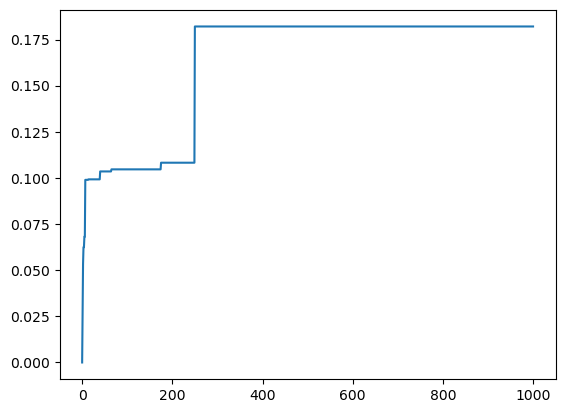

In [ ]:

agent=NeuralNetwork(5,[10,20],4)
agent.set_genes(population[0])
fit2=runTrial(agent,10,co=0)
print(fit2)

0


## Natural walk

In [238]:
reset()
robot=bp.Biped(p,path+robot_urdf_path,position=[0, 0, .15])
start=robot.get_position()
#[LH, LA, RH RA]
pattern=[
         [0,0.5,0,0.5],
         [-0.5,0.5,-0.5,0.5],
         [-0.5,0,-0.5,0],
         [-0.5,-0.5,-0.5,-0.5],
         [0,0,0,0],
]
for k in range(2):
    for i in range(len(pattern)):
        robot.set_positions(pattern[i])
        for j in range(150):
            p.stepSimulation()
            time.sleep(1./240.)

    for j in range(100):
            p.stepSimulation()
end=robot.get_position()
print(start,"\n",end)


(-0.000609095676819213, 0.02969637854918617, 0.11290467951335718) 
 (0.03174368755549595, -0.014088657467038255, 0.11293892665547695)


torch.Size([5, 4])
Loss 0.23237714171409607
Loss 0.5505387783050537
Loss 0.9233226776123047
Loss 0.21606692671775818
Loss 0.0448627732694149
torch.Size([100, 4])


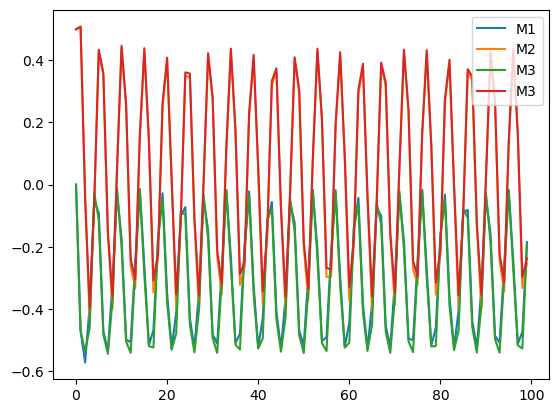

2.4236949666596583

In [239]:
net=RNN(4,8)

# Setup our loss function
loss_fn = nn.MSELoss()

# Setup our optimizer
optimizer = optim.SGD(net.parameters, lr=0.01)
x_data=torch.tensor(pattern)
y_data=torch.roll(x_data, -1, 0)
print(x_data.shape)
# Training loop
for epoch in range(1000):
    optimizer.zero_grad()
    # init hidden state
    for t in range(x_data.size(0)):
        x_t = x_data[t]
        y_t = y_data[t]
        # predict next hidden and state
        y_t_hat = net.forward(x_t)
        # accumulate loss
        loss = loss_fn(y_t_hat, y_t)
        loss.backward()
        optimizer.step()  
        if epoch%1000==0:
            print("Loss",loss.item())


c=torch.zeros((100,4))
y=torch.zeros((100,4))
c[0]=x_data[0]
for i in range(1,100):
    c[i]=net.forward(c[i-1])

print(c.shape)
plt.plot(c.detach().numpy(),label=["M1","M2","M3","M3"])
#plt.plot(pattern+pattern+pattern+pattern+pattern+pattern)
plt.legend(loc="upper right")
plt.show()

runTrial(net,10,co=0)

In [241]:

reset()
robot=bp.Biped(p,path+robot_urdf_path,position=[0, 0, .15])
start_pos=robot.get_position()
for i in range(100):
    positions=torch.tensor(robot.positions())
    out=net.forward(positions)#np.concatenate([positions,friction],axis=0))
    outputs=out.flatten()
    outputs[outputs>.5]=.5
    outputs[outputs<-.5]=-.5
    robot.set_positions(outputs)
    p.stepSimulation()
    time.sleep(1./240.)
    for i in range(250): #time between each
        p.stepSimulation()

### Evolution

In [252]:
population=[deepcopy(net.get_genes())+torch.tensor(np.random.normal(0,0.5,net.get_genes().shape),dtype=torch.float32) for i in range(250)]
fitnesses=microbial(population,1000,0.4)
plt.plot(fitnesses)
plt.show()

Generation 1 best fitness = 0
